## Setup

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from numba import jit, njit
from tqdm.auto import tqdm
from utils.functions import functions
from utils.bits import find_int_number_of_bits, bit_metrics, \
                        bits_to_value, value_to_bits, \
                        bitstring_to_array, array_to_bitstring
from utils.sa import sa, acc_prob_ln, acc_prob_e
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

tqdm.pandas()

root = 'experiments'

## Plot configuration

In [2]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.style.use('grayscale')
figsize33 = (17, 10) # (17, 12)
title_fontsize = 30

## Data Loading

In [3]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <    np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def load_exp1_results(root):
    exp1_root = os.path.join('experiments', 'experiment_1_ln_vs_exp')
    exp_root = os.path.join(exp1_root, f'exp_best')
    ln_root = os.path.join(exp1_root, f'ln_best')
    
    def load_runs(_root):
        results = []
        for run_path in os.listdir(_root):
            run = pd.read_parquet(os.path.join(_root, run_path))
            results.append(run)
        return pd.concat(results).drop(columns=['apf_param', 'p_max'])
    
    exp_runs = load_runs(exp_root)
    ln_runs = load_runs(ln_root)

    exp_runs['apf'] = 'exp'
    ln_runs['apf'] = 'ln'
    return pd.concat([exp_runs, ln_runs])

def load_exp2_results(root):
    exp2_root = os.path.join('experiments', 'experiment_2_classic_methods', 'classic_sa')

    def load_runs(_root):
        results = []
        for run_path in os.listdir(_root):
            run = pd.read_parquet(os.path.join(_root, run_path))
            results.append(run)
        return pd.concat(results)
    
    return load_runs(exp2_root)

def load_detailed_runs():
    detailed_root = os.path.join('experiments', 'experiment_2_classic_methods', 'outcomes')
    results = []
    for run_path in tqdm(os.listdir(detailed_root), leave=False):
        run = pd.read_parquet(os.path.join(detailed_root, run_path))
        run_id, apf, target, d = os.path.splitext(run_path)[0].split('_')
        run['ap'] = apf.split('=')[1]
        run['target'] = target.split('=')[1]
        run['n_dims'] = int(d.split('=')[1])
        run = run.reset_index().rename(columns={'index':'iteration'})
        results.append(run)
    return pd.concat(results)

# Use this only if you want to load the scores at all iterations.
# Data from 30 runs require 64GB RAM.
# def _load_split_seq():
#     split_seq_cache_location = 'cache/agg_split_seq.parquet'
#     if os.path.exists(split_seq_cache_location):
#         agg_split_seq = pd.read_parquet(split_seq_cache_location)
#     else:
#         half_split_root = os.path.join('experiments', 'experiment_3_sequential_runs', 'sequential_split_runs')
#         split_results = []
#         for run_path in tqdm(os.listdir(half_split_root), leave=False):
#             run = pd.read_parquet(os.path.join(half_split_root, run_path))
#             run_id, target, d, split, stage = os.path.splitext(run_path)[0].split('_')
#             run['target'] = target.split('=')[1]
#             run['n_dims'] = int(d.split('=')[1])
#             run['split'] = float(split.split('=')[1])
#             stage = stage.split('=')[1]
#             si, total = stage.split('of')
#             run['stage'] = int(si)
#             run['total'] = int(total)
#             run = run.reset_index().rename(columns={'index':'iteration'})
#             split_results.append(reduce_mem_usage(run))
#         results_split_seq = reduce_mem_usage(pd.concat(split_results))
#         del split_results
#         for outcome in range(3):
#             results_split_seq[f'o{outcome}'] = results_split_seq.outcomes==outcome

#         agg_split_seq = results_split_seq.groupby(['target', 'n_dims', 'iteration', 'split', 'stage'])\
#                 [['o0', 'o1', 'o2', 'accept_probs', 'scores']].mean().reset_index()
#         agg_split_seq = agg_split_seq.rename(columns={'o0':'Refused', 'o1':'Improvement', \
#                                     'o2':'Worse accepted', 'accept_probs':'Accept. Prob.'})
#         agg_split_seq.to_parquet(split_seq_cache_location)
#         del results_split_seq
#     return agg_split_seq

# def load_n_seq():
#     n_seq_cache_location = 'cache/agg_n_seq.parquet'
#     if os.path.exists(n_seq_cache_location):
#         agg_n_seq = pd.read_parquet(n_seq_cache_location)
#     else:
#         n_seq_root = os.path.join('experiments', 'experiment_3_sequential_runs', 'sequential_n_runs')
#         n_seq_results = []
#         for run_path in tqdm(os.listdir(n_seq_root), leave=False):
#             try:
#                 run = pd.read_parquet(os.path.join(n_seq_root, run_path))
#                 run_id, target, d, stage = os.path.splitext(run_path)[0].split('_')
#                 run['target'] = target.split('=')[1]
#                 run['n_dims'] = int(d.split('=')[1])
#                 stage = stage.split('=')[1]
#                 si, total = stage.split('of')
#                 run['stage'] = int(si)
#                 run['total'] = int(total)
#                 run = run.reset_index().rename(columns={'index':'iteration'})
#                 n_seq_results.append(reduce_mem_usage(run))
#             except Exception as e:
#                 pass
#         results_n_seq = pd.concat(n_seq_results)
#         results_n_seq = reduce_mem_usage(results_n_seq)
#         del n_seq_results
#         for outcome in range(3):
#             results_n_seq[f'o{outcome}'] = results_n_seq.outcomes==outcome

#         agg_n_seq = results_n_seq.groupby(['target', 'n_dims', 'iteration', 'stage', 'total'])\
#                 [['o0', 'o1', 'o2', 'accept_probs', 'scores']].mean().reset_index()
#         agg_n_seq = agg_n_seq.rename(columns={'o0':'Refused', 'o1':'Improvement', \
#                                     'o2':'Worse accepted', 'accept_probs':'Accept. Prob.'})
#         agg_n_seq.to_parquet(n_seq_cache_location)
#         del results_n_seq
#     return agg_n_seq

In [4]:
def load_exp2_budget_results(root, budget):
    assert budget in [50, 5000]
    exp2_root = os.path.join('experiments', 'experiment_2_classic_methods', f'budget_{budget}')

    def load_runs(_root):
        results = []
        for run_path in os.listdir(_root):
            run = pd.read_parquet(os.path.join(_root, run_path))
            results.append(run)
        return pd.concat(results)
    
    return load_runs(exp2_root)

results2_50 = load_exp2_budget_results(root, 50)
results2_5000 = load_exp2_budget_results(root, 5000)

In [5]:
def load_split_seq_2():
    split_seq_cache_location = 'cache/agg_split_seq.parquet'
    if os.path.exists(split_seq_cache_location):
        results = pd.read_parquet(split_seq_cache_location)
    else:
        half_split_root = os.path.join('experiments', 'experiment_3_sequential_runs', \
                                       'sequential_split_runs')
        split_results = []
        results = []
        
        for run_path in tqdm(os.listdir(half_split_root), leave=False):
            run = pd.read_parquet(os.path.join(half_split_root, run_path))
            run_id, target, d, split, stage = os.path.splitext(run_path)[0].split('_')
            stage = stage.split('=')[1]
            si, total = stage.split('of')
            results.append({
                'target':target.split('=')[1],
                'n_dims':int(d.split('=')[1]),
                'split':float(split.split('=')[1]),
                'stage':int(si),
                'total':int(total),
                'min_score':run.scores.min(),
            })
        results = pd.DataFrame(results)
        results.to_parquet(split_seq_cache_location)
    return results

def load_n_seq_2():
    n_seq_cache_location = 'cache/agg_n_seq.parquet'
    if os.path.exists(n_seq_cache_location):
        agg_n_seq = pd.read_parquet(n_seq_cache_location)
    else:
        n_seq_root = os.path.join('experiments', 'experiment_3_sequential_runs', 'sequential_n_runs')
        n_seq_results = []
        n_results = []
        for run_path in tqdm(os.listdir(n_seq_root), leave=False):
            try:
                run = pd.read_parquet(os.path.join(n_seq_root, run_path))
                run_id, target, d, stage = os.path.splitext(run_path)[0].split('_')
                stage = stage.split('=')[1]
                si, total = stage.split('of')
                n_results.append({
                    'target':target.split('=')[1],
                    'n_dims':int(d.split('=')[1]),
                    'stage':int(si),
                    'total':int(total),
                    'min_score':run.scores.min()
                })
            except Exception as e:
                pass
        agg_n_seq = pd.DataFrame(n_results)
        agg_n_seq.to_parquet(n_seq_cache_location)
    return agg_n_seq

In [6]:
results1 = load_exp1_results(root)
results2 = load_exp2_results(root)
results3 = load_detailed_runs()

results_split = load_split_seq_2()
results_nseq = load_n_seq_2()

  0%|          | 0/2160 [00:00<?, ?it/s]

In [7]:
# quick patch
results2.rename(columns={'ap':'apf'}, inplace=True)
results2_50.rename(columns={'ap':'apf'}, inplace=True)
results2_5000.rename(columns={'ap':'apf'}, inplace=True)
results3.rename(columns={'ap':'apf', 'scores':'min_score'}, inplace=True)
results_split.rename(columns={'scores':'min_score'}, inplace=True)
results_nseq.rename(columns={'scores':'min_score'}, inplace=True)

In [8]:
def add_distance_to_min(df):
    df['real_min'] = 0
    df.loc[df.target=='Rana', 'real_min'] = \
        -511.7043 * df.query('target=="Rana"').n_dims + 511.68714
    df.loc[df.target=='Eggholder', 'real_min'] = \
        -915.61991 * df.query('target=="Eggholder"').n_dims + 862.10466
    df['d_min'] = df.min_score - df.real_min

add_distance_to_min(results1)
add_distance_to_min(results2)
add_distance_to_min(results3)
add_distance_to_min(results_split)
add_distance_to_min(results_nseq)

add_distance_to_min(results2_50)
add_distance_to_min(results2_5000)

## Plots.ln vs exp
- [x] boxplots at d=20
- [x] median lineplots at all dimensions

In [9]:
plots_root = 'plots'
os.makedirs(plots_root, exist_ok=True)

def _savefig(fig, filename, experiment):
    experiment_root = os.path.join(plots_root, f'experiment{experiment}')
    upload_root = os.path.join(plots_root, 'upload')
    os.makedirs(experiment_root, exist_ok=True)
    os.makedirs(upload_root, exist_ok=True)
    basename = f'exp{experiment}_{filename}'
    fig.savefig(os.path.join(experiment_root, f'{basename}.eps'), format='EPS')
    fig.savefig(os.path.join(upload_root, f'{basename}.eps'), format='EPS')
    fig.savefig(os.path.join(experiment_root, f'{basename}.png'))

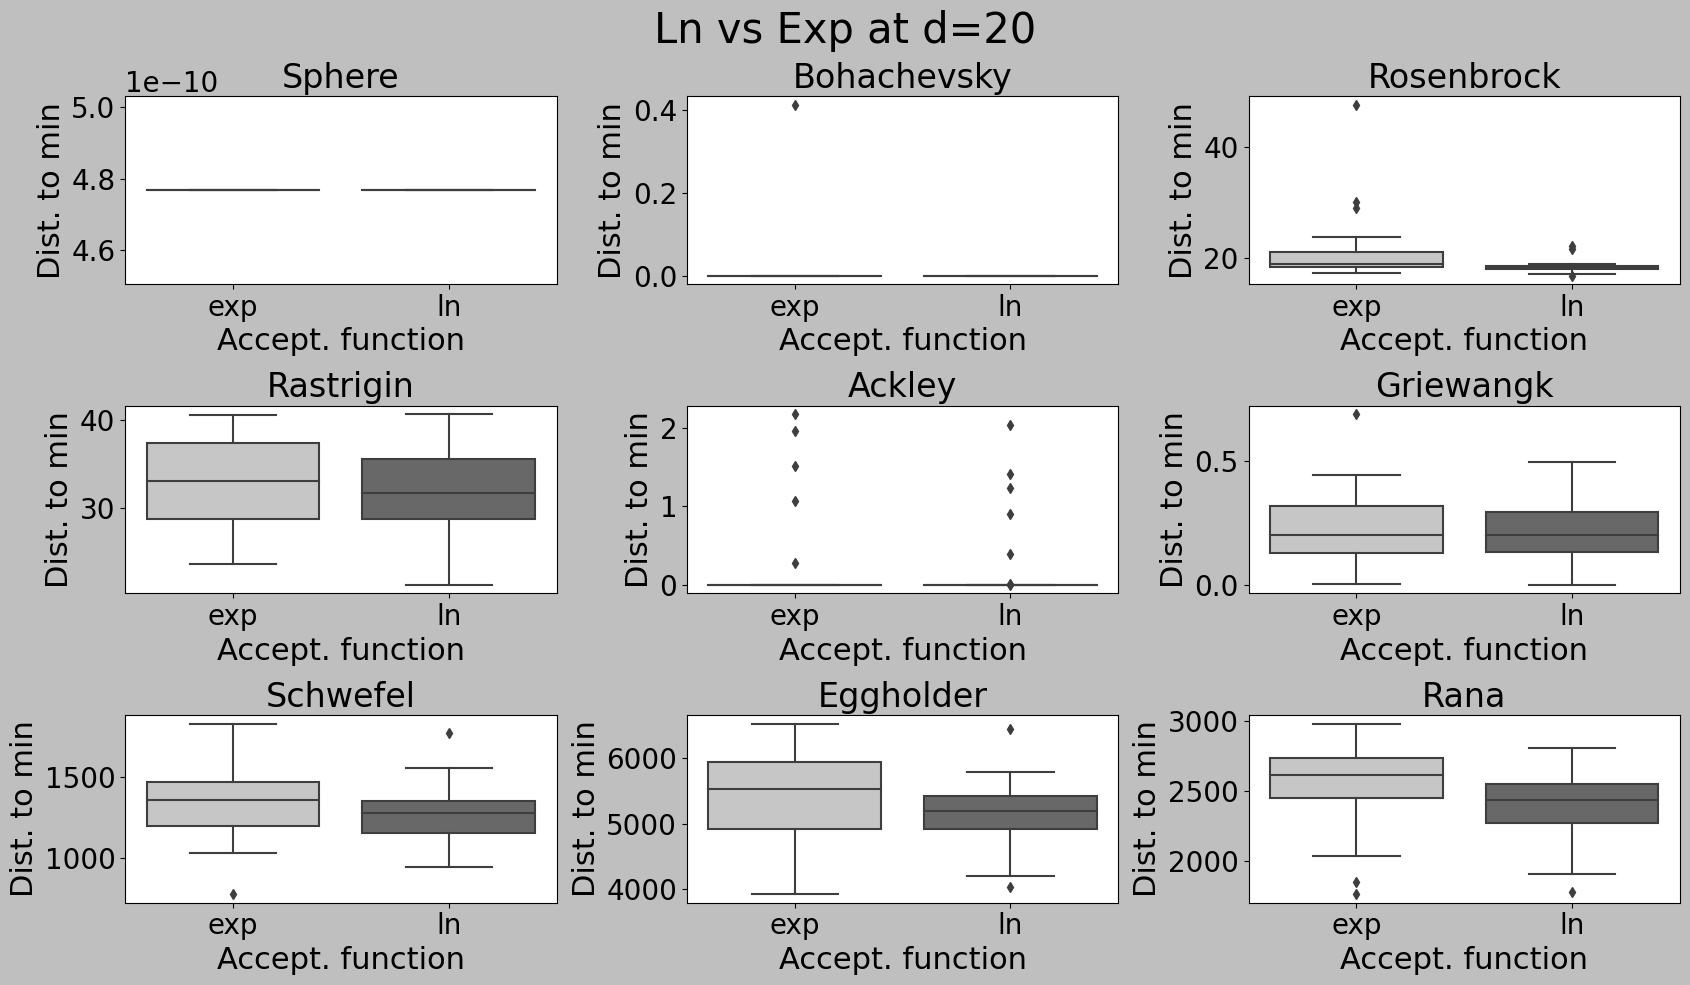

In [10]:
def _boxplot33(data, fig_title, x_col, x_label, y_col, y_label, \
            file_name, experiment):
    fig, ax = plt.subplots(3, 3, figsize=figsize33)
    _ = plt.suptitle(fig_title, fontsize=title_fontsize)
    for i, target in enumerate(functions):
        _df = data[data.target==target.name]
        this_ax = ax[i // 3, i % 3]
        sns.boxplot(x=x_col, y=y_col, data=_df, ax=this_ax, palette=('Greys'));
        this_ax.set_title(target.name);
#         _ = this_ax.set_xticklabels(ap_names)
        this_ax.set_xlabel(x_label);
        this_ax.set_ylabel(y_label);
    fig.tight_layout()
    _savefig(fig, file_name, experiment=experiment)

_boxplot33(data=results1.query('n_dims==20'), fig_title='Ln vs Exp at d=20', \
           x_col='apf', x_label='Accept. function', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_exp_boxplots', experiment=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


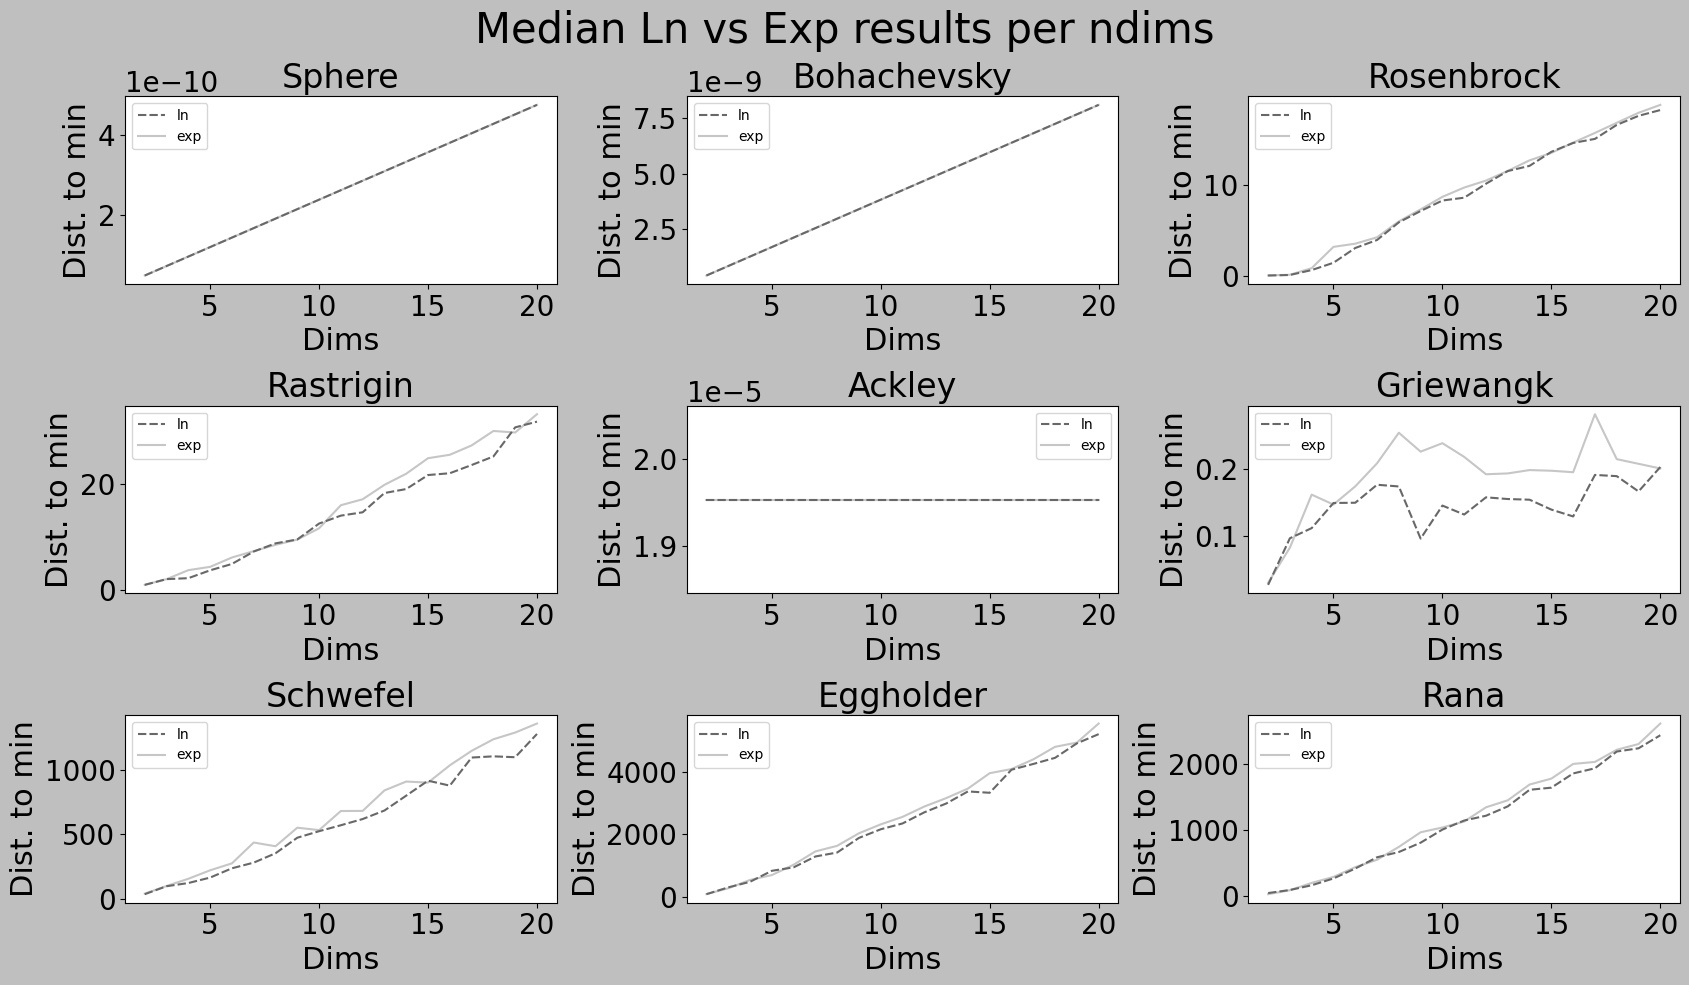

In [11]:
def _lineplot33(data, fig_title, x_col, x_label, y_col, y_label, \
            file_name, experiment, hue=None):
    fig, ax = plt.subplots(3, 3, figsize=figsize33)
    _ = plt.suptitle(fig_title, fontsize=title_fontsize)

    for i, target in enumerate(functions):
        _df = data[data.target==target.name]
        max_x = _df[x_col].max()
        ap_order = list(data.query(f'{x_col}==@max_x').sort_values(y_col)[hue].values.astype(str))

        this_ax = ax[i // 3, i % 3]
        _ = sns.lineplot(x=x_col, y=y_col, hue=hue, data=_df, ax=this_ax, style=hue, palette=('Greys'))
        _ = this_ax.set_title(target.name)
    #     _ = this_ax.set_xticklabels(['boltz', 'fast', 'exp', 'ln'])
        _ = this_ax.set_xlabel(x_label)
        _ = this_ax.set_ylabel(y_label)

        handles, labels = this_ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), 
                                      key=lambda t: ap_order.index(t[0]), reverse=True))
        _ = this_ax.legend(handles, labels)

    fig.tight_layout()
    _savefig(fig, file_name, experiment=experiment)
    
y_col = 'd_min' # d_min, min_score
agg1 = results1.groupby(['apf', 'target', 'n_dims'])[y_col].apply(np.median).reset_index()

_lineplot33(data=agg1, fig_title='Median Ln vs Exp results per ndims', \
           x_col='n_dims', x_label='Dims', \
           y_col=y_col, y_label='Dist. to min', \
           file_name='ln_vs_exp_lineplots', experiment=1, hue='apf')

In [12]:
# exp_agg1 = agg1.query('apf=="exp"').set_index(['target', 'n_dims']).d_min
# ln_agg1 = agg1.query('apf=="ln"').set_index(['target', 'n_dims']).d_min

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


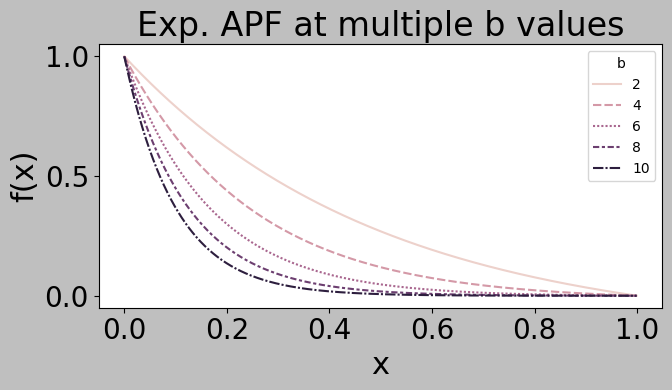

In [13]:
x = np.arange(0, 1, 1e-3)
data = []
for xi in x:
    for b in np.arange(2, 12, 2):
        data.append({
            'b':b,
            'f(x)': (np.exp(b * (1 - xi)) - 1) / (np.exp(b) - 1),
            'x':xi,
        })
data = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(7, 4))
_ = sns.lineplot(x='x', y='f(x)', data=data, hue='b', style='b')
_ = ax.set_title('Exp. APF at multiple b values')
fig.tight_layout()
_savefig(fig, 'exp_multiple_b_values', experiment=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


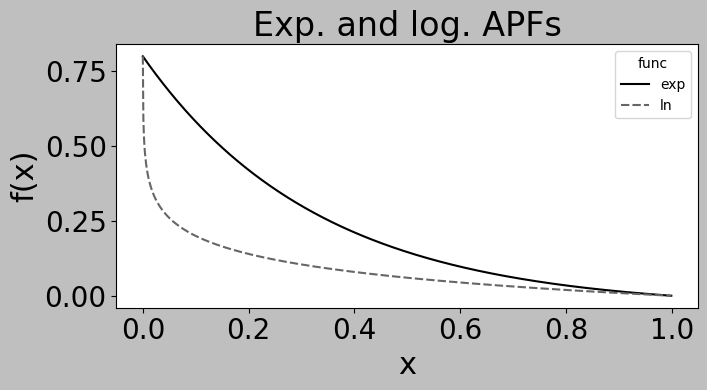

In [14]:
x = np.arange(0, 1, 1e-3)
data = []
b = 3
t = 1e-4
for xi in x:
    data.append({
        'func':'exp',
        'f(x)': 0.8 * (np.exp(b * (1 - xi)) - 1) / (np.exp(b) - 1),
        'x':xi,
    })
    data.append({
        'func':'ln',
        'f(x)': 0.8 * np.log(xi * (1 - t) + t) / np.log(t),
        'x':xi,
    })
data = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(7, 4))
_ = sns.lineplot(x='x', y='f(x)', data=data, hue='func', style='func')
_ = ax.set_title('Exp. and log. APFs')
fig.tight_layout()
_savefig(fig, 'best_ln_best_exp', experiment=0)

In [15]:
data.pivot(index='x', columns='func', values='f(x)').cumsum()

func,exp,ln
x,,
0.000,0.800000,0.800000
0.001,1.597478,1.391729
0.002,2.392442,1.927294
0.003,3.184898,2.429030
0.004,3.974856,2.906482
...,...,...
0.995,225.149046,87.222545
0.996,225.149552,87.222893
0.997,225.149931,87.223154


## Plots. Ln vs classical SA methods
- [x] boxplots at d=20
- [x] median lineplots at all dimensions

In [16]:
merged2 = pd.concat([results2.query('apf!="ln"'), results1.query('apf=="ln"')])

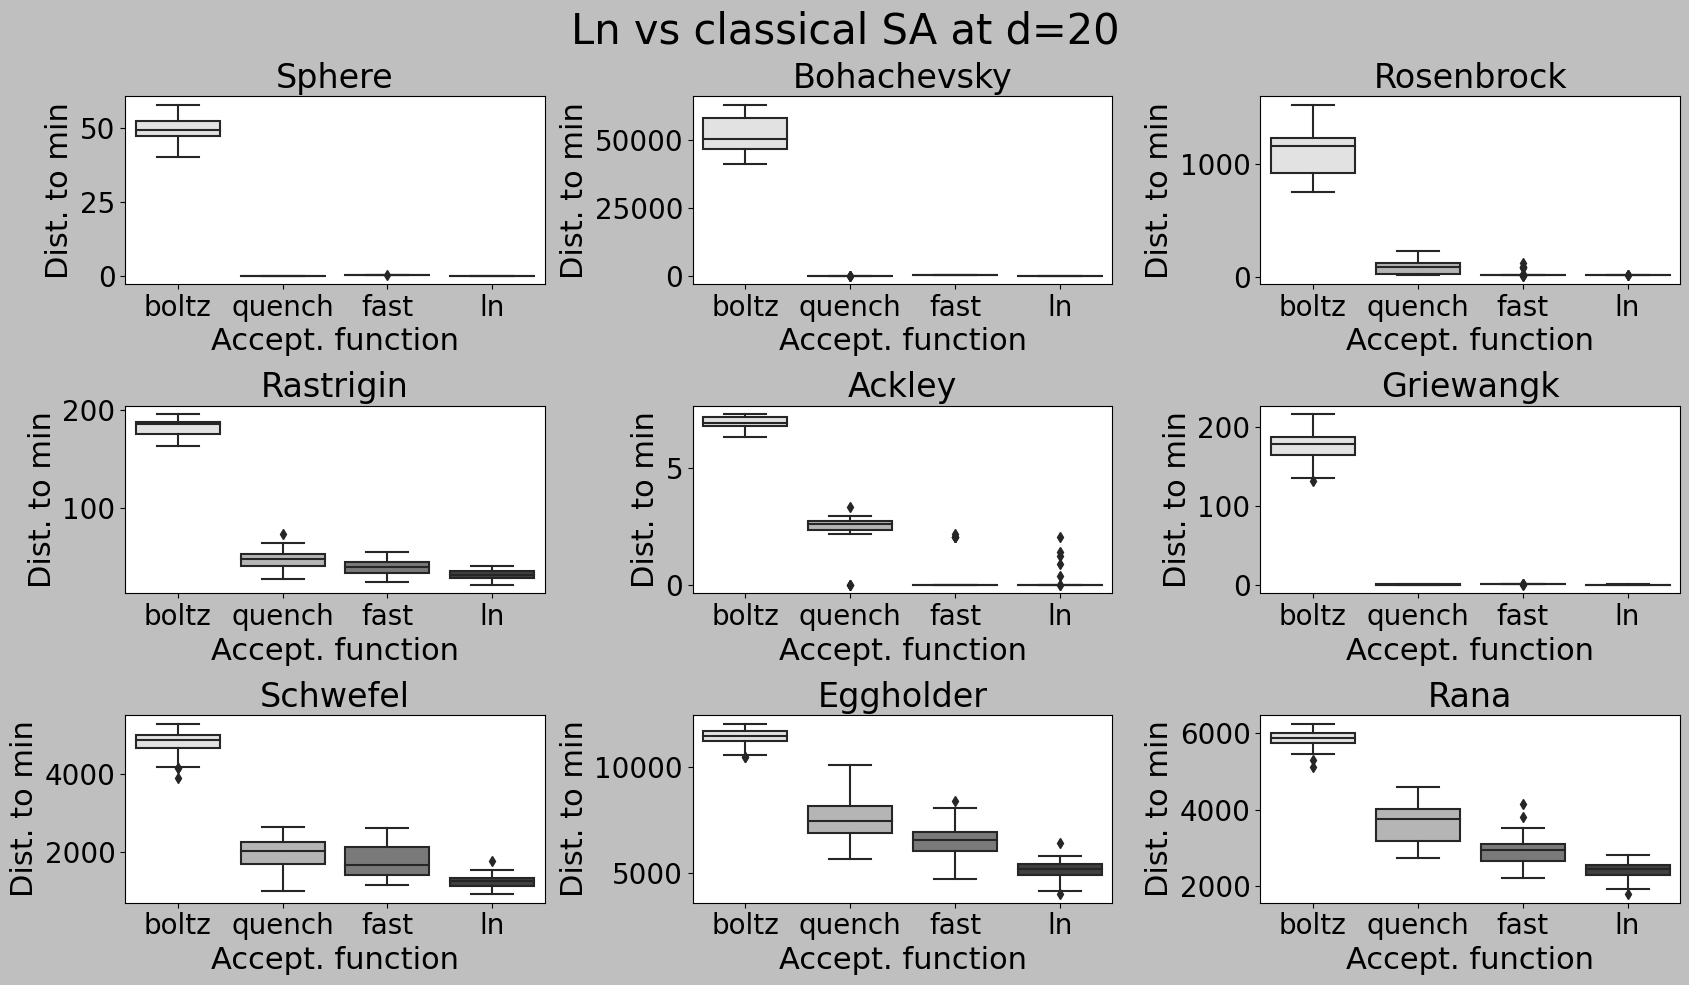

In [17]:
_boxplot33(data=merged2.query('n_dims==20'), fig_title='Ln vs classical SA at d=20', \
           x_col='apf', x_label='Accept. function', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_classical_boxplots', experiment=2)

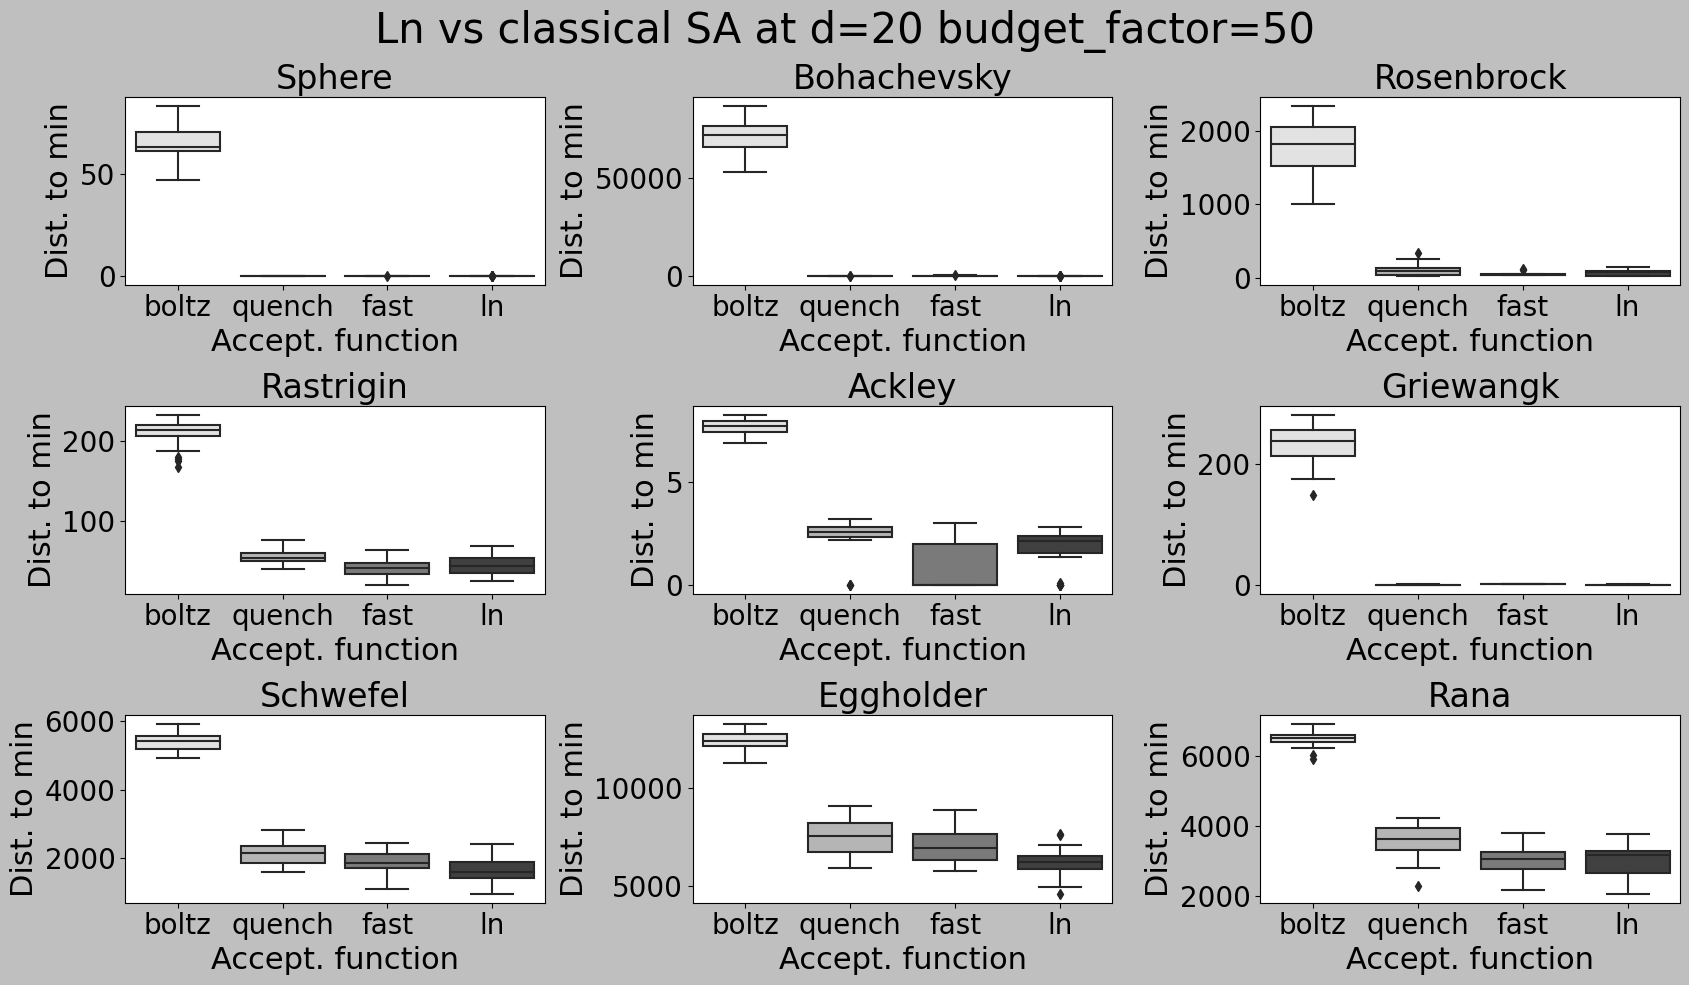

In [18]:
_boxplot33(data=results2_50.query('n_dims==20'), \
           fig_title='Ln vs classical SA at d=20 budget_factor=50', \
           x_col='apf', x_label='Accept. function', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_classical_boxplots_budget_50', experiment=2)

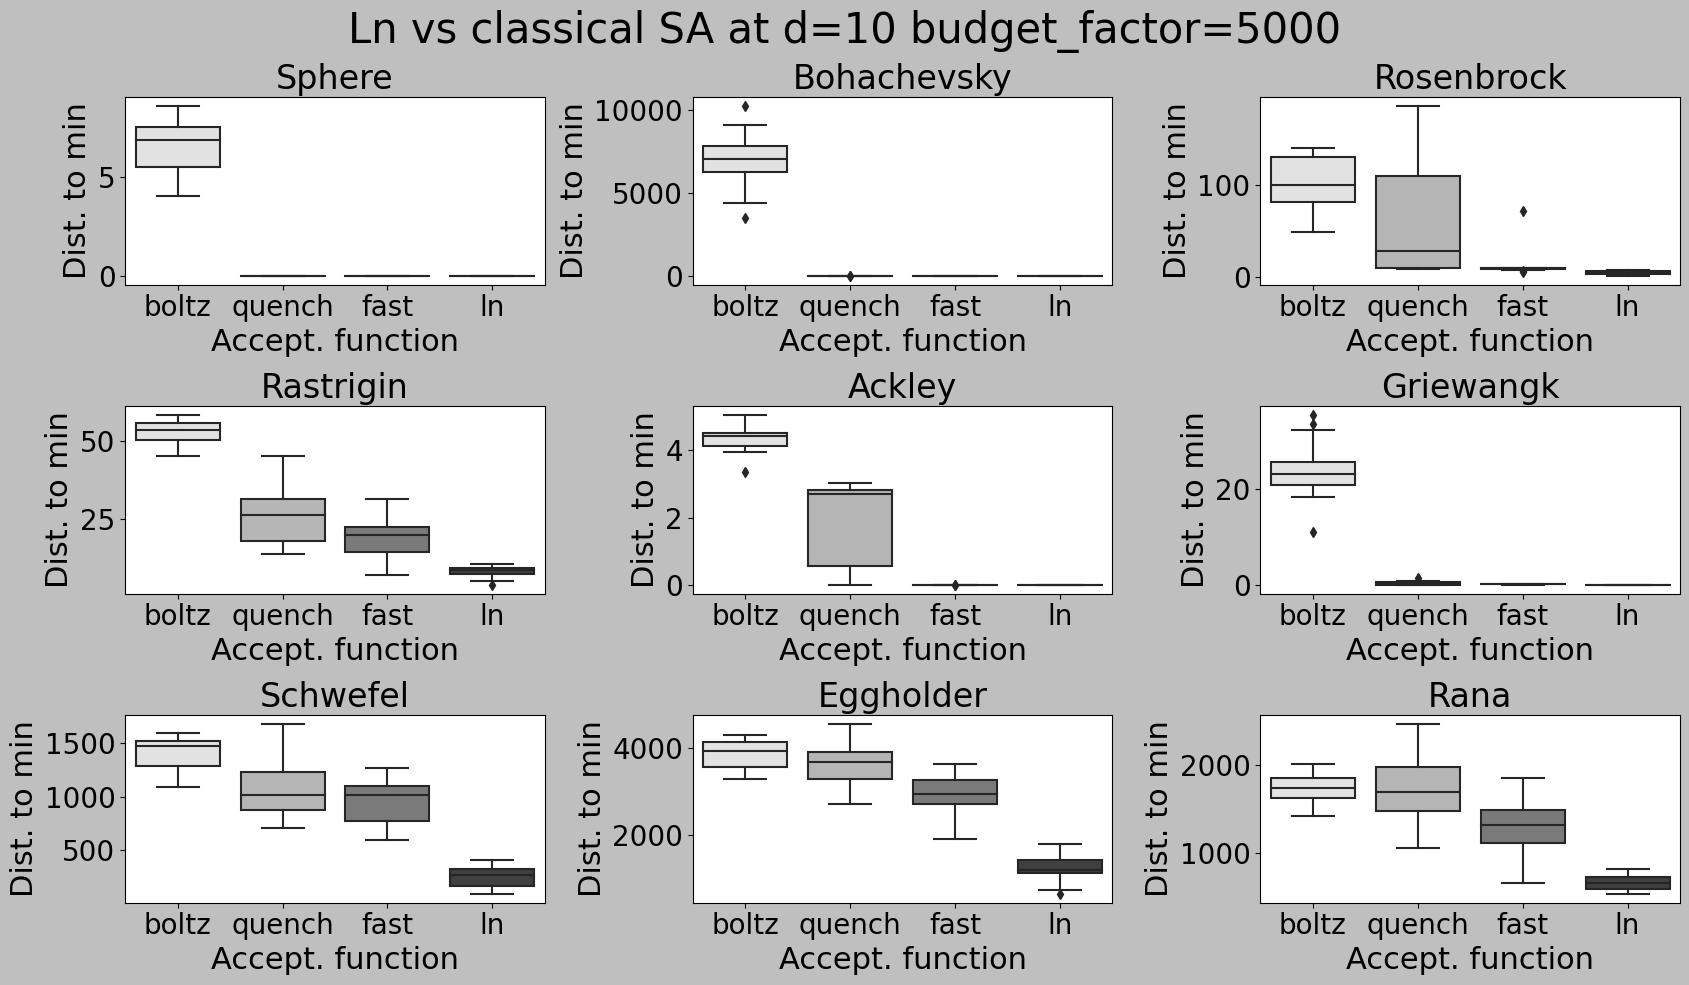

In [19]:
_boxplot33(data=results2_5000.query('n_dims==10'), \
           fig_title='Ln vs classical SA at d=10 budget_factor=5000', \
           x_col='apf', x_label='Accept. function', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_classical_boxplots_budget_5000', experiment=2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


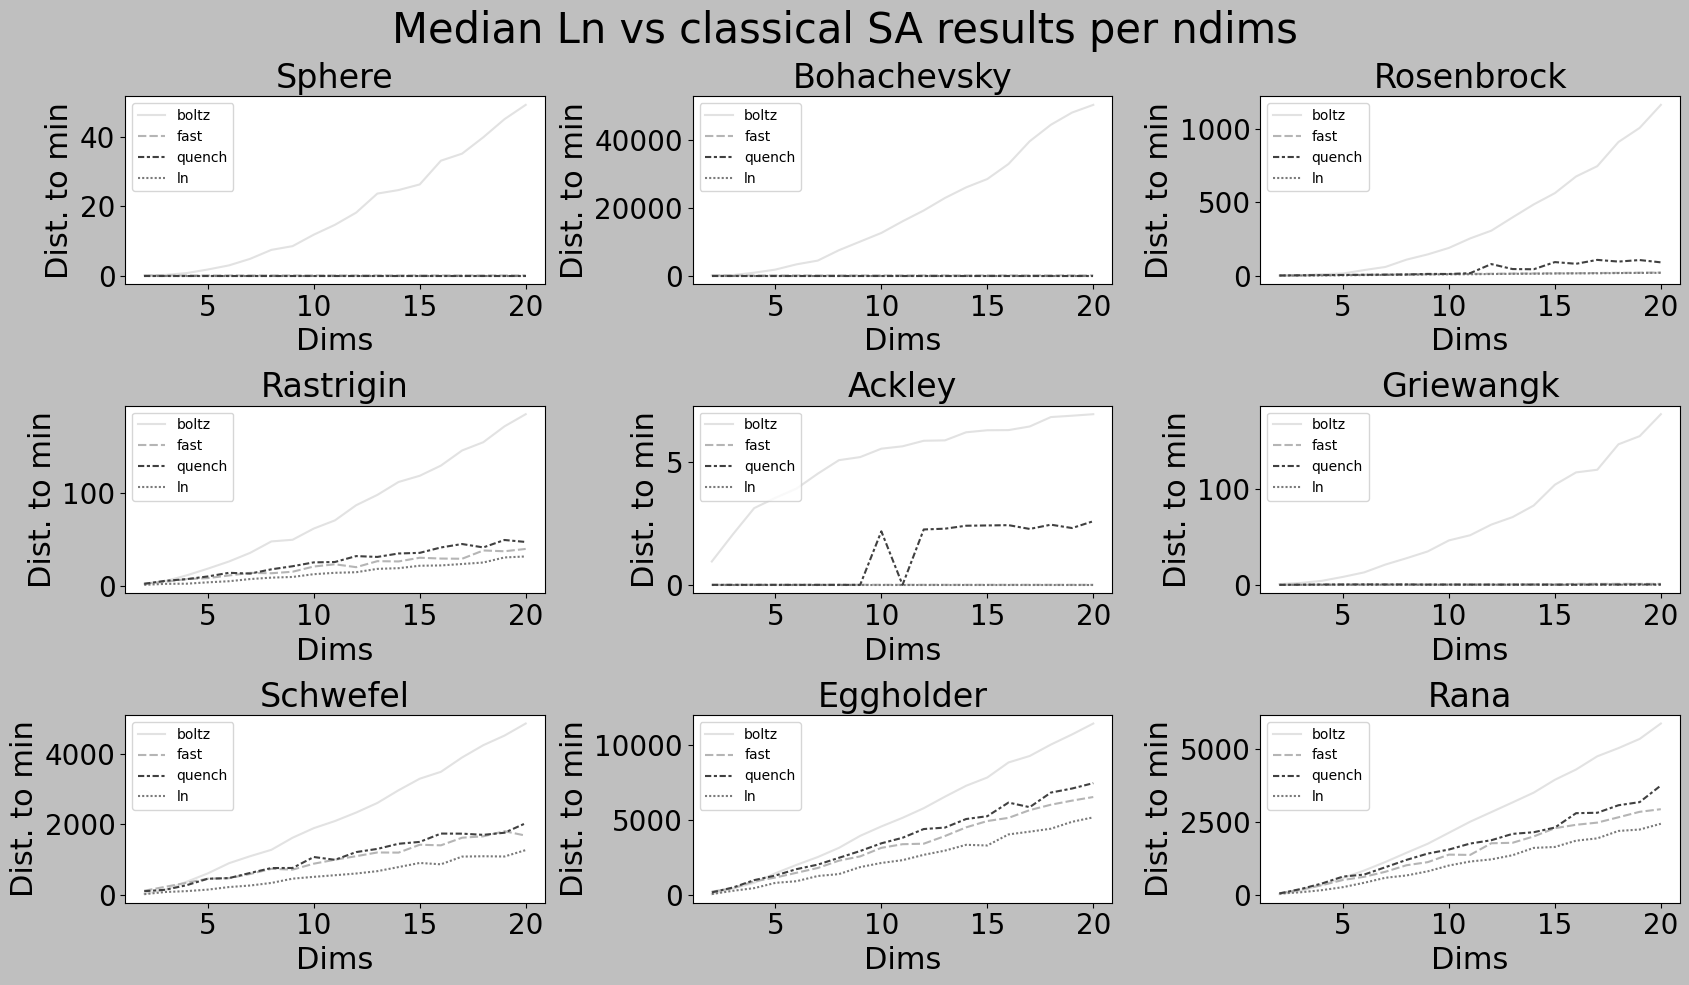

In [20]:
y_col = 'd_min' # d_min, min_score
agg2 = merged2.groupby(['apf', 'target', 'n_dims'])[y_col].apply(np.median).reset_index()

_lineplot33(data=agg2, fig_title='Median Ln vs classical SA results per ndims', \
           x_col='n_dims', x_label='Dims', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_classical_lineplots', experiment=2, hue='apf')

## Plots. Outcomes
- [x] Effective acceptance rates: 3x3 for each function.
- [x] Expected min score at each moment: 3x3 lineplots for each apf (3 classical + ln).

In [21]:
for outcome in range(3):
    results3[f'o{outcome}'] = results3.outcomes==outcome
    
agg3 = results3.groupby(['apf', 'target', 'iteration', 'n_dims']) \
        [['o0', 'o1', 'o2', 'accept_probs', 'd_min']].mean().reset_index()
agg3 = agg3.rename(columns={'o0':'Refused', 'o1':'Improvement', \
                            'o2':'Worse accepted', 'accept_probs':'Accept. Prob.'})

In [22]:
tmp3 = agg3.groupby(['apf', 'target', 'n_dims']).apply(\
        lambda group: group.set_index('iteration')['Accept. Prob.'].rolling(100).mean())\
        .to_frame().reset_index().dropna()

In [23]:
vmins = results3.groupby(['target', 'n_dims']).d_min.min()
vmaxs = results3.groupby(['target', 'n_dims']).d_min.max()
ranges = (vmaxs - vmins).to_frame()
ranges.reset_index().pivot(index='target', columns='n_dims', values='d_min')

n_dims,2,10
target,,
Ackley,14.302622,13.515400
Bohachevsky,25703.489217,161888.222516
Eggholder,1781.410445,9873.311453
Griewangk,180.724736,606.307934
Rana,987.069220,6034.078518
Rastrigin,80.693203,324.962775
Rosenbrock,3447.856951,12543.934353
Schwefel,1668.926673,5666.487206
Sphere,52.053528,200.294095


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


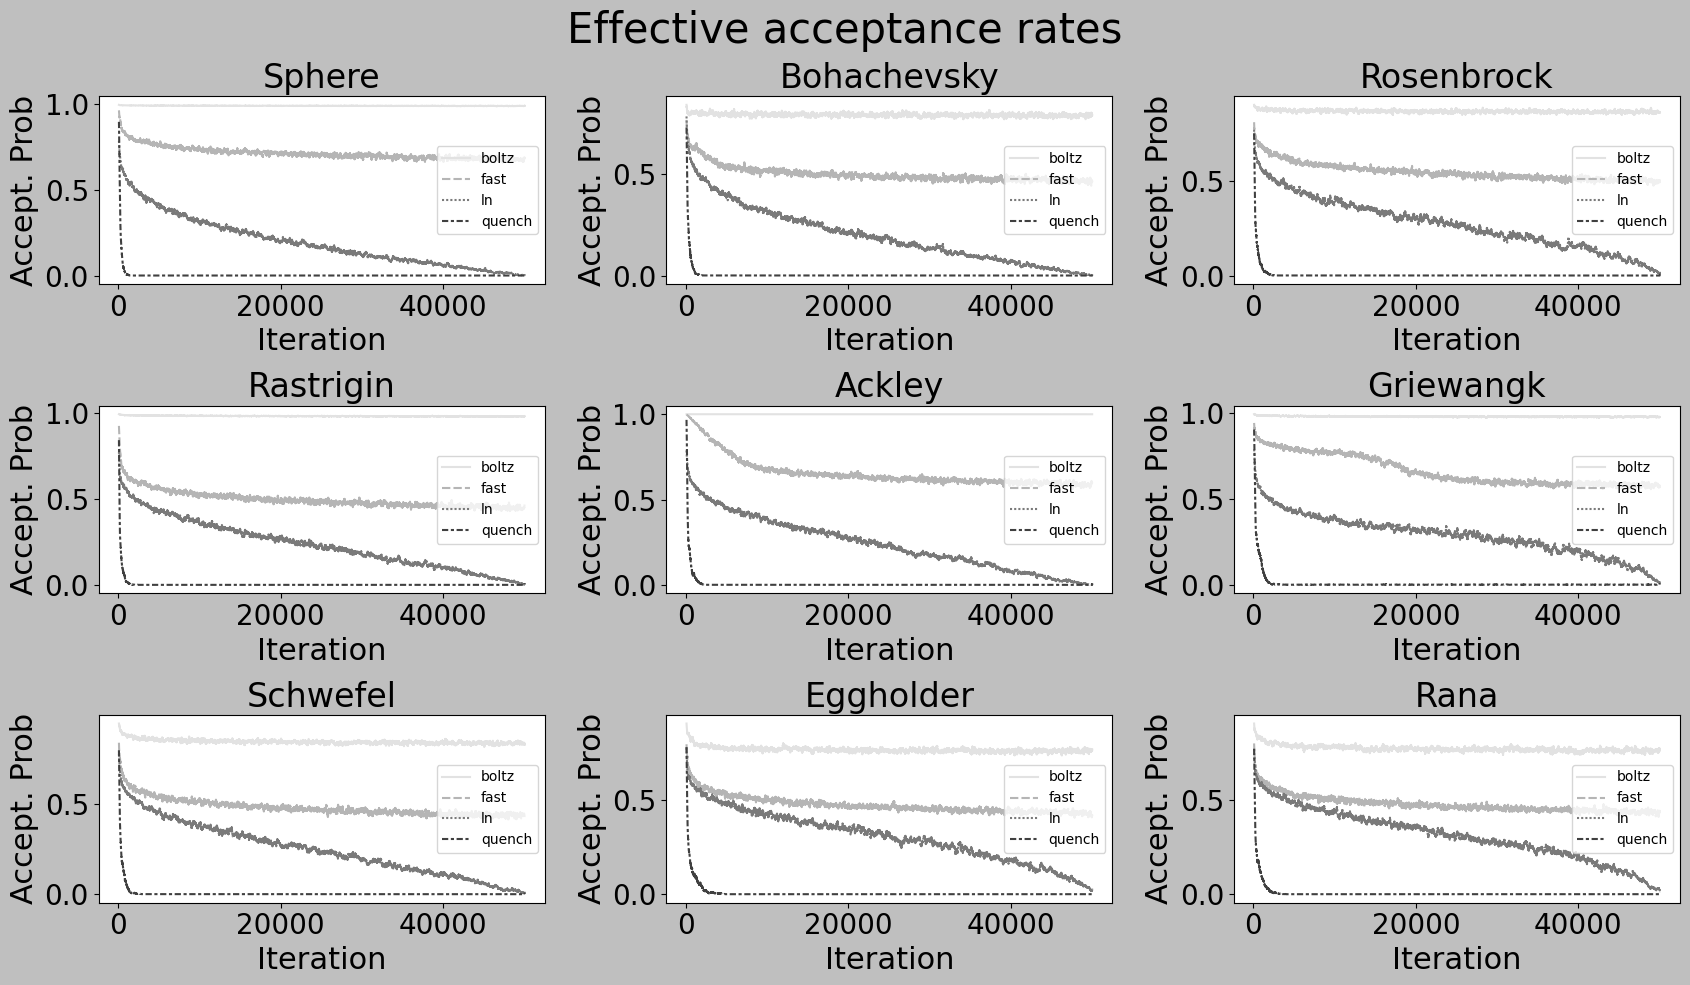

In [24]:
_lineplot33(data=tmp3.query('n_dims==10'), fig_title='Effective acceptance rates', \
           x_col='iteration', x_label='Iteration', \
           y_col='Accept. Prob.', y_label='Accept. Prob', \
           file_name='effective_ap_rates_lineplots', experiment=2, hue='apf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


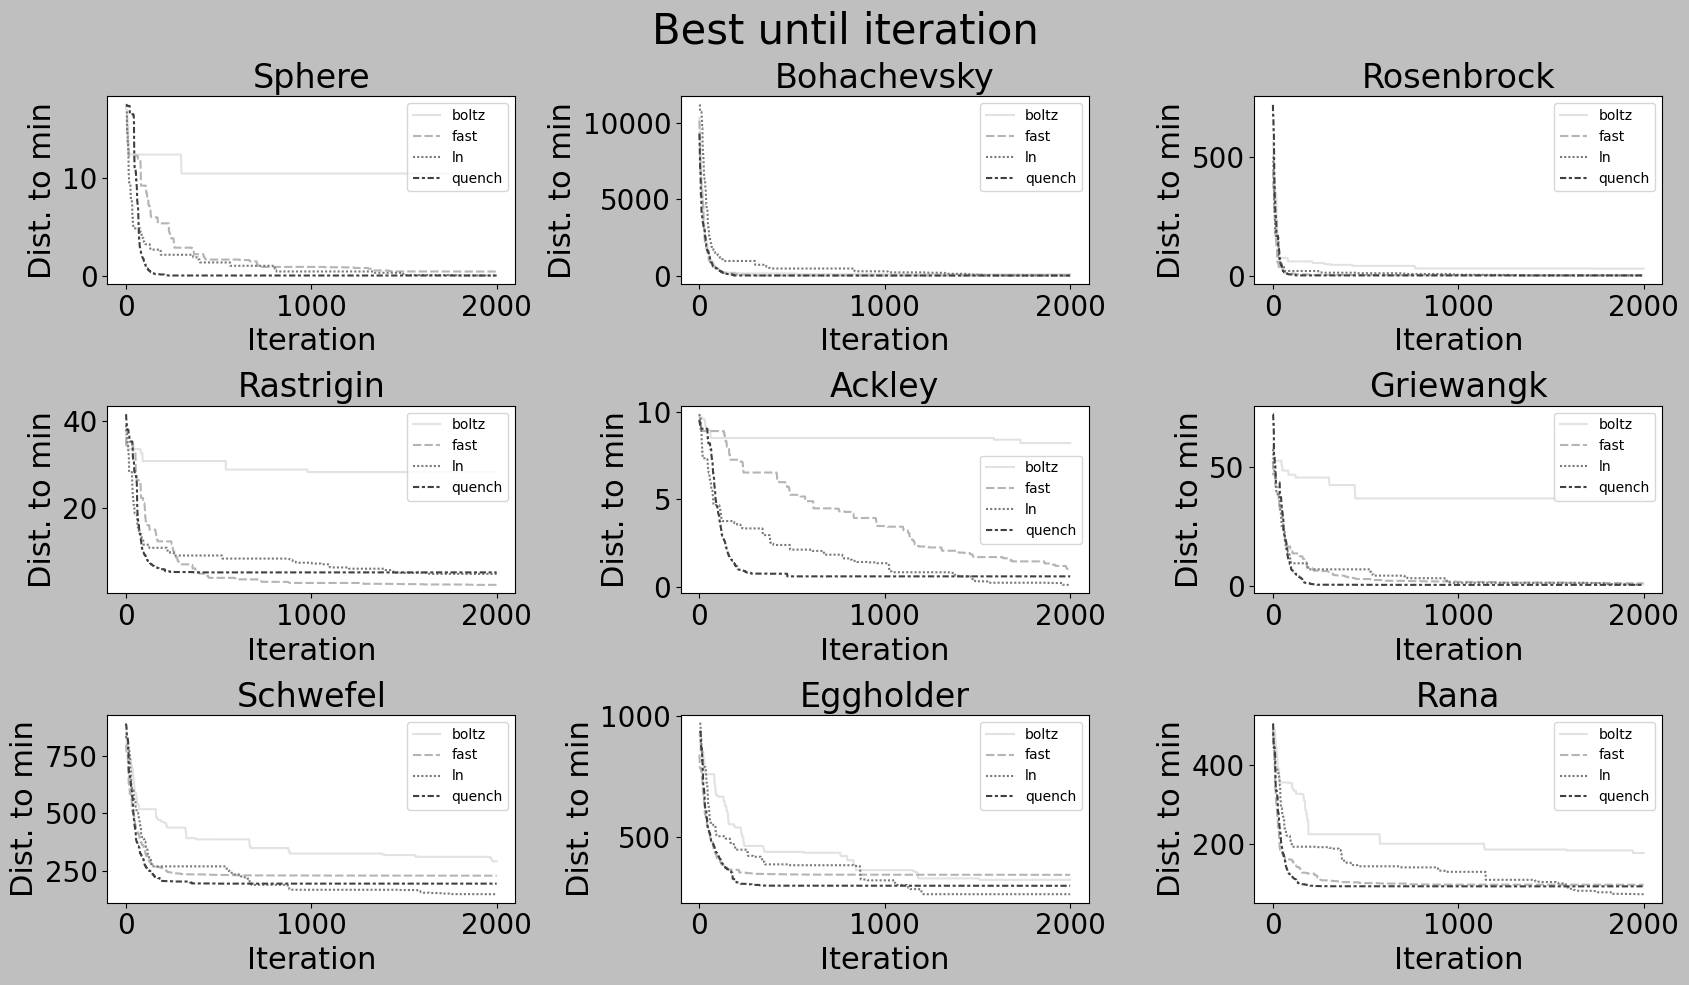

In [33]:
min_so_far = agg3.groupby(['apf', 'target', 'n_dims']).apply(\
        lambda group: group.set_index('iteration')['d_min'].expanding().min())\
        .to_frame().reset_index().dropna()
_lineplot33(data=min_so_far.query('n_dims==2'), fig_title='Best until iteration', \
           x_col='iteration', x_label='Iteration', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='ln_vs_classical_best_so_far', experiment=3, hue='apf')

## Plots. Sequential runs
- [x] Two unequal sequences.
    - [x] boxplots at d=20
    - [x] lineplots with median score
- [x] N equal sequences.
    - [x] boxplots at d=20
    - [x] lineplots with median score

In [26]:
# plt.style.use('grayscale')
# sns.set_theme('paper')

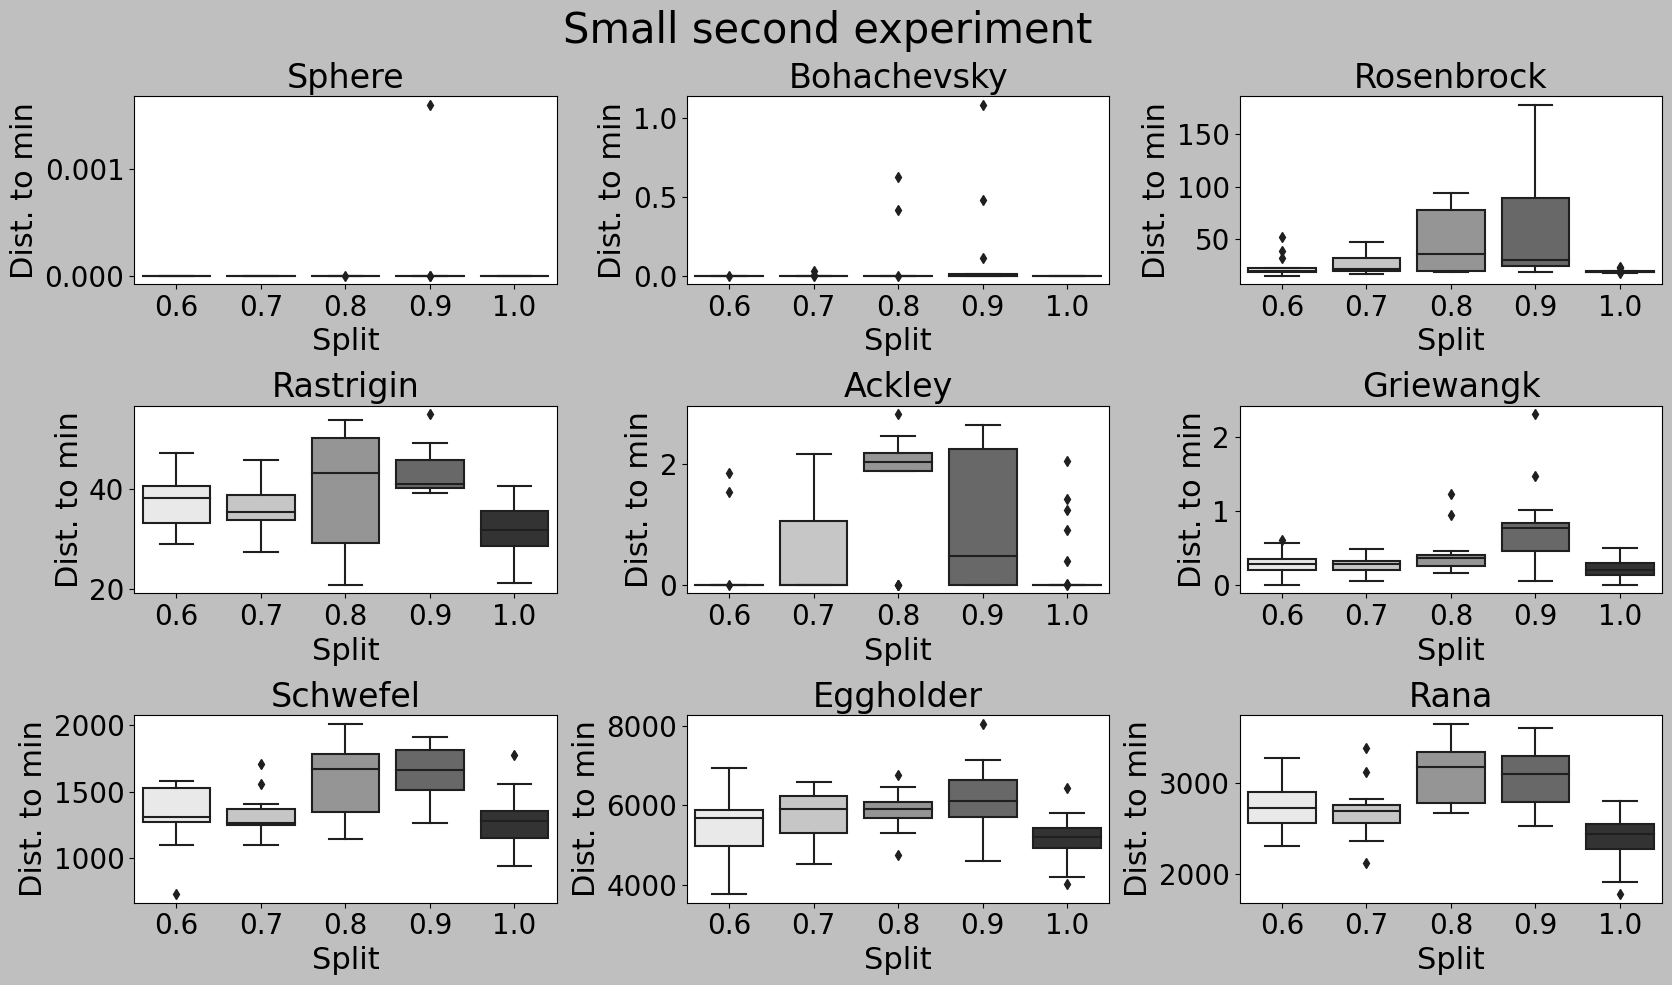

In [27]:
split = results_split.query('stage==total').drop(columns=['stage', 'total', 'min_score', 'real_min'])
full = results1.query('apf=="ln"')[['target', 'n_dims', 'd_min']]
full['split'] = 1.0

merged3 = pd.concat([split, full])

_boxplot33(data=merged3.query('n_dims==20'), fig_title='Small second experiment', \
           x_col='split', x_label='Split', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='unequal_splits_boxplots', experiment=4)

In [28]:
# agg3 = merged3.groupby(['split', 'target', 'n_dims'])['d_min'].apply(np.median).reset_index()

# _lineplot33(data=agg3, fig_title='Unequal splits', \
#            x_col='n_dims', x_label='Dims', \
#            y_col='d_min', y_label='Value', \
#            file_name='unequal_splits', experiment=3, hue='split')

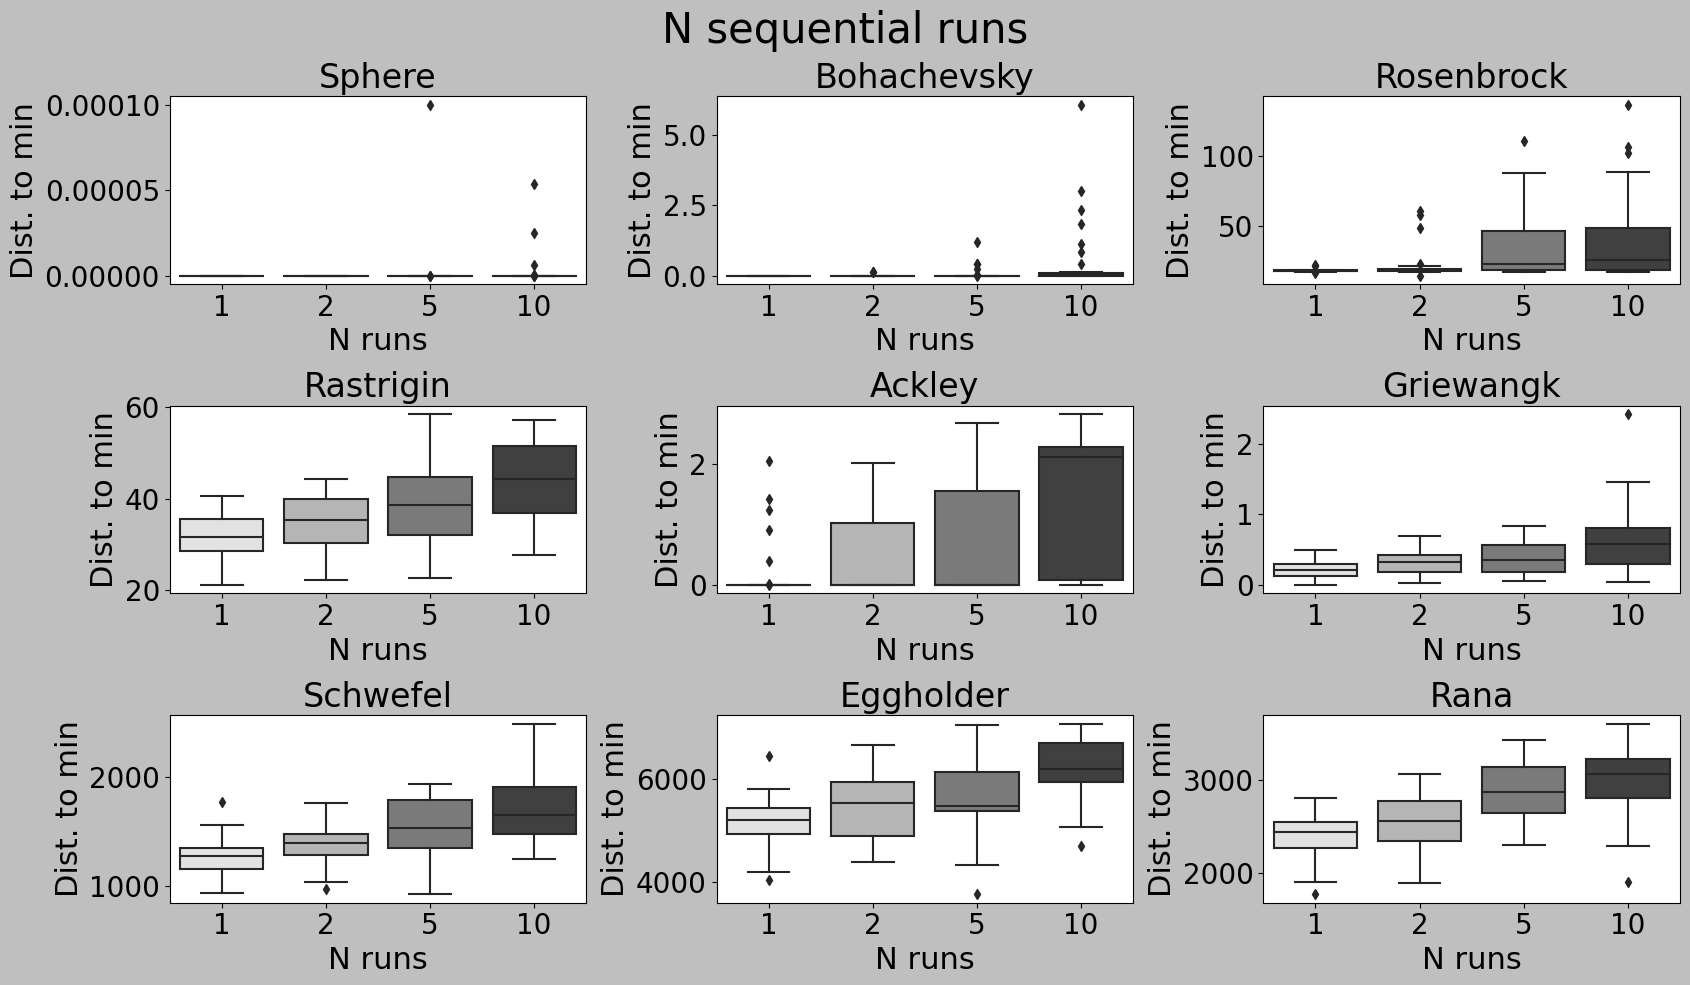

In [29]:
nseq = results_nseq.query('stage==total').drop(columns=['stage', 'min_score', 'real_min'])
full = results1.query('apf=="ln"')[['target', 'n_dims', 'd_min']]
full['total'] = 1

merged32 = pd.concat([nseq, full])

_boxplot33(data=merged32.query('n_dims==20'), fig_title='N sequential runs', \
           x_col='total', x_label='N runs', \
           y_col='d_min', y_label='Dist. to min', \
           file_name='n_runs_boxplots', experiment=4)

In [30]:
# agg32 = merged32.groupby(['total', 'target', 'n_dims'])['d_min'].apply(np.median).reset_index()

# _lineplot33(data=agg32, fig_title='N runs', \
#            x_col='n_dims', x_label='Dims', \
#            y_col='d_min', y_label='Value', \
#            file_name='n_runs_lineplots', experiment=4, hue='total')